##Question 1##
Convolutional Autoencoder for Fashion data

##I used pytorch for quesiton1 and 2 , for question3, i used keras##

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import torch
from   torch.autograd import Variable

import numpy as np
import torchvision
from   torchvision import datasets, transforms
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)  

In [3]:

# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

0it [00:00, ?it/s]

26427392it [00:04, 5786116.39it/s]                              


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 41160.69it/s]                           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


4423680it [00:02, 1661226.05it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


8192it [00:00, 14167.43it/s]            

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:

# Use standard FashionMNIST dataset test
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [0]:

IMAGE_SIZE = 784
IMAGE_WIDTH = IMAGE_HEIGHT = 28

# Hyperparameters
code_size = 20
num_epochs = 50
batch_size = 128
lr = 0.002
optimizer_cls = optim.Adam

In [0]:
##load train and test
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=4)

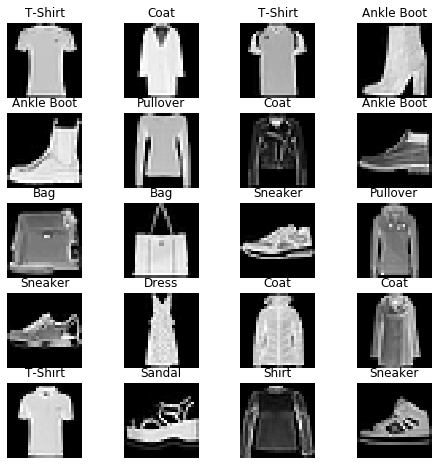

In [13]:
##show the data
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')
def imshow(img):
  npimg = img.numpy() #convert the tensor to numpy for displaying the image
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
labels=['Shirt','Sneaker','Bag','Ankle Boot']
plt.figure(figsize = (3,3)) 

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

##Convolutional Autoencoder 
using a convolutional autoencoder to encode and decode images in the Fashion-MNIST dataset. The encoding piece uses 2 convolutional layrers of dimensionaliy 16, 8  and each kernel is of size 3x3, stride is 2, using max-pooling from a 2x2 matrix after each convolutional layer. The decoder piece is simply the reverse of the encoder, uses 2 conv layers of dimensionality  8 and 16 with each layer followed by an up-sampling layer of size 2x2 matrix.

In [0]:

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        

    def forward(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        
        return x


In [0]:
autoencoder = ConvAutoencoder()
loss_fn = nn.BCELoss()
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)


In [68]:
n_epochs = 30
train_losses=[]
test_losses=[]
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = autoencoder(images)
        # calculate the loss
        loss = loss_fn(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss/len(train_loader))
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss/len(train_loader)
        ))         
    # print avg training statistics 
    

 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.075626
Epoch: 2 	Training Loss: 0.075380
Epoch: 3 	Training Loss: 0.075201
Epoch: 4 	Training Loss: 0.075048
Epoch: 5 	Training Loss: 0.074936
Epoch: 6 	Training Loss: 0.074805
Epoch: 7 	Training Loss: 0.074740
Epoch: 8 	Training Loss: 0.074629
Epoch: 9 	Training Loss: 0.074553
Epoch: 10 	Training Loss: 0.074493
Epoch: 11 	Training Loss: 0.074431
Epoch: 12 	Training Loss: 0.074406
Epoch: 13 	Training Loss: 0.074349
Epoch: 14 	Training Loss: 0.074315
Epoch: 15 	Training Loss: 0.074291
Epoch: 16 	Training Loss: 0.074271
Epoch: 17 	Training Loss: 0.074231
Epoch: 18 	Training Loss: 0.074212
Epoch: 19 	Training Loss: 0.074208
Epoch: 20 	Training Loss: 0.074168
Epoch: 21 	Training Loss: 0.074142
Epoch: 22 	Training Loss: 0.074119
Epoch: 23 	Training Loss: 0.074095
Epoch: 24 	Training Loss: 0.074076
Epoch: 25 	Training Loss: 0.074041
Epoch: 26 	Training Loss: 0.073990
Epoch: 27 	Training Loss: 0.073958
Epoch: 28 	Training Loss: 0.073923
Epoch: 29 	Training Loss: 0.0

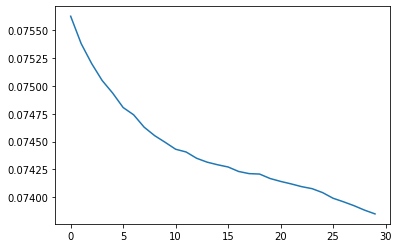

In [69]:
plt.plot(train_losses,label = "Train losses")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


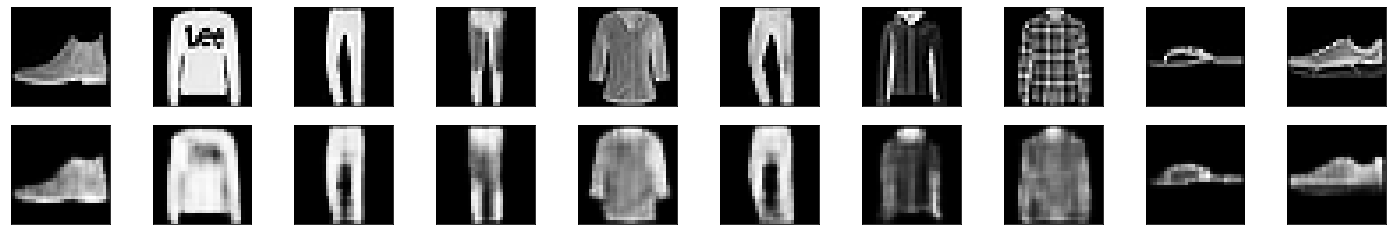

In [71]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = autoencoder(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


From the result, it is showed the decoding results display the original images and the reconstructed images. 

##Question 2##
2 layers cnn
##2.1 Using ConvNets##
uisng CNNs in this problem to classify the various clothing items in the fashion MNIST dataset. We get a final accuracy of 90.85% on the test set. The architecture of the CNN is as follows.

A 2D convolution layer of 32 kernels of size 5x5.
Max polling over a 2x2 area to downsample the output.
Another 2D convolution layer of 32 kernels of size 5*5.
rical crossentropy since this is a multi class classification problem.
The choices for the size of the convolution layers and dense layer are standard baseline numbers for image classification problems.

In [0]:

import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [0]:
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# function to do evaluation (calculate the accuracy) in gpu
def evaluation(dataloader):
     total, correct = 0, 0
     #keeping the network in evaluation mode 
     model.eval()
     for data in dataloader:
         inputs, labels = data
         #moving the inputs and labels to gpu
         inputs, labels = inputs.to(device), labels.to(device)
         outputs = model(inputs)
         _, pred = torch.max(outputs.data, 1)
         total += labels.size(0)
         correct += (pred == labels).sum().item()
     return 100 * correct / total

In [0]:
epoch=50

In [0]:
test_losses=[]
test_losses=[]
for e in range(epoch):
    train_loss = 0
    test_loss = 0
    accuracy = 0
    for images, labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        op = model(images)
        loss = criterion(op, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                log_ps = model(images)
                prob = torch.exp(log_ps)
                top_probs, top_classes = prob.topk(1, dim=1)
                equals = labels == top_classes.view(labels.shape)
                accuracy += equals.type(torch.FloatTensor).mean()
                test_loss += criterion(log_ps, labels)
        model.train()
    print("Epoch: {}/{}.. ".format(e+1, epoch),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
        

Epoch: 1/50..  Training Loss: 0.034..  Test Loss: 0.531..  Test Accuracy: 0.918
Epoch: 2/50..  Training Loss: 0.012..  Test Loss: 0.614..  Test Accuracy: 0.918
Epoch: 3/50..  Training Loss: 0.008..  Test Loss: 0.595..  Test Accuracy: 0.917
Epoch: 4/50..  Training Loss: 0.015..  Test Loss: 0.630..  Test Accuracy: 0.910
Epoch: 5/50..  Training Loss: 0.019..  Test Loss: 0.558..  Test Accuracy: 0.919
Epoch: 6/50..  Training Loss: 0.011..  Test Loss: 0.636..  Test Accuracy: 0.911
Epoch: 7/50..  Training Loss: 0.016..  Test Loss: 0.650..  Test Accuracy: 0.915
Epoch: 8/50..  Training Loss: 0.017..  Test Loss: 0.556..  Test Accuracy: 0.919
Epoch: 9/50..  Training Loss: 0.005..  Test Loss: 0.642..  Test Accuracy: 0.922
Epoch: 10/50..  Training Loss: 0.016..  Test Loss: 0.640..  Test Accuracy: 0.913
Epoch: 11/50..  Training Loss: 0.013..  Test Loss: 0.661..  Test Accuracy: 0.912
Epoch: 12/50..  Training Loss: 0.014..  Test Loss: 0.637..  Test Accuracy: 0.918
Epoch: 13/50..  Training Loss: 0.011.

In [0]:

plt.plot(train_losses,label = "Train losses")
plt.plot(test_losses, label = "Test losses")
plt.legend()

In [0]:
import numpy as np

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

In [0]:

image,labels = next(iter(test_loader))

In [0]:
imshow(image[0])

In [0]:
def view_classify(img, ps, version="MNIST", title = 0):
    ''' Function for viewing an image and it's predicted classes.
    '''
    title_order = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(title_order, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.title("True: " + title_order[title])

In [0]:

def display_test(i):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    img = images[i]
    lbl = labels[i]
    with torch.no_grad():
        output = model.forward(img)
    ps = torch.exp(output)
    view_classify(img.view(1,28,28), ps, version='Fashion', title=lbl)
    

In [93]:

for i in range(10):
    r = np.random.randint(0,63)
    display_test(r)

RuntimeError: ignored

##Question3##
##USING KERAS FOR Q3#
#cnn and rnn


In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
    
# plot training accuracy and loss for each training epoch
def plot_model_training_results(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def plot_roc_curve(y_test, y_predicted, model_name):
  
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_predicted)
  
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve for ' + model_name + ' model')
  plt.legend(loc='best')
  plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
import  pandas as pd



going to use Kaggle dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
url      420464 non-null object
label    420464 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [18]:
from gensim.corpora import Dictionary
di = list(urls['url'].map(lambda x: list(x)))
dct = Dictionary(di)  
print("here is how the dictionary looks like...")
print(dct.token2id)

here is how the dictionary looks like...
{'.': 0, 'a': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'i': 7, 'm': 8, 'o': 9, 'r': 10, 't': 11, 'y': 12, 'n': 13, 'p': 14, 's': 15, 'u': 16, 'k': 17, 'l': 18, 'z': 19, 'h': 20, 'w': 21, 'b': 22, 'v': 23, '/': 24, '=': 25, '?': 26, 'x': 27, '-': 28, '1': 29, '2': 30, '9': 31, '_': 32, '0': 33, '7': 34, '8': 35, 'j': 36, '3': 37, '6': 38, '&': 39, ';': 40, 'A': 41, 'F': 42, 'G': 43, 'D': 44, 'H': 45, 'L': 46, '4': 47, '5': 48, 'q': 49, 'B': 50, 'K': 51, 'R': 52, 'N': 53, 'P': 54, 'O': 55, 'T': 56, 'M': 57, 'V': 58, 'C': 59, ':': 60, 'S': 61, 'E': 62, 'X': 63, 'J': 64, 'I': 65, '+': 66, 'á': 67, 'Q': 68, 'Y': 69, 'U': 70, 'W': 71, 'Z': 72, '%': 73, '[': 74, ']': 75, 'ó': 76, 'ñ': 77, 'í': 78, '¡': 79, '³': 80, '¿': 81, 'Â': 82, 'Ã': 83, ' ': 84, '@': 85, '~': 86, '<': 87, '>': 88, '{': 89, '}': 90, '\xad': 91, '¼': 92, '½': 93, 'à': 94, 'ï': 95, '¸': 96, 'Þ': 97, '¨': 98, 'ª': 99, 'µ': 100, 'Ò': 101, '×': 102, '¤': 103, '§': 104, '®': 105, '¹': 

In [20]:
X = list(urls['url'].map(lambda x: dct.doc2idx(list(x))))
print("random input samples..")
print(X[:10])
y = urls['label']

random input samples..
[[3, 7, 1, 10, 12, 9, 5, 1, 6, 1, 8, 4, 1, 3, 3, 7, 2, 11, 0, 2, 9, 8], [4, 15, 14, 3, 4, 15, 7, 6, 13, 0, 2, 9, 8, 0, 1, 16], [7, 1, 8, 1, 6, 1, 8, 4, 1, 3, 3, 7, 2, 11, 0, 2, 9, 8], [17, 1, 18, 1, 13, 11, 19, 7, 15, 0, 13, 4, 11], [15, 18, 7, 6, 20, 11, 18, 12, 9, 5, 5, 2, 4, 13, 11, 4, 10, 0, 13, 4, 11], [11, 9, 3, 3, 15, 2, 1, 10, 21, 1, 15, 20, 0, 2, 9, 8], [11, 16, 22, 4, 8, 9, 23, 7, 4, 19, 0, 2, 9, 8], [7, 14, 18, 0, 20, 17], [2, 10, 1, 2, 17, 15, 14, 7, 3, 4, 10, 0, 16, 15, 24, 11, 9, 9, 18, 22, 1, 10, 24, 7, 13, 15, 11, 1, 18, 18, 0, 14, 20, 14, 26, 14, 1, 2, 17, 25, 4, 27, 4], [14, 9, 15, 28, 17, 16, 14, 1, 13, 6, 0, 2, 9, 8, 24]]


In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1603)
print("length of training set X_train {}, y_train {}".format(len(X_train), len(y_train)))
print("length of training set X_test {}, y_test {}".format(len(X_test), len(y_test)))
print(X_train[0])
print(y_test[:10])

length of training set X_train 281710, y_train 281710
length of training set X_test 138754, y_test 138754
[8, 9, 10, 11, 1, 18, 7, 13, 15, 11, 10, 16, 8, 4, 13, 11, 15, 0, 2, 9, 8, 24, 8, 9, 10, 11, 1, 18, 5, 1, 49, 0, 20, 11, 8, 18]
326094    0
143606    0
12115     1
371188    0
264135    0
410944    1
81068     0
186562    0
212724    0
88914     0
Name: label, dtype: int64


In [22]:
##RNN WITH KERAS

from keras.preprocessing import sequence
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
from keras.models import Sequential
import numpy as np

Using TensorFlow backend.


In [23]:
maxindx = 50
X_train = sequence.pad_sequences(X_train, maxindx, padding="post", truncating="post")
X_test = sequence.pad_sequences(X_test, maxindx, padding="post", truncating="post")
X_train[0]

array([ 8,  9, 10, 11,  1, 18,  7, 13, 15, 11, 10, 16,  8,  4, 13, 11, 15,
        0,  2,  9,  8, 24,  8,  9, 10, 11,  1, 18,  5,  1, 49,  0, 20, 11,
        8, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

##simple rnn##

using a simple RNN to classify URLs into benign and malicious. As shown in the output of the code below, we get an f1 score accuracy of 96%, classfication accuracy of 98% for benign class and 86% for malicious class.



In [24]:
max_features = len(dct)
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, 64))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1, activation='sigmoid'))

In [25]:
rnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print(rnn_model.summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          11456     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)




Train on 225368 samples, validate on 56342 samples
Epoch 1/100





225368/225368 [==============================] - 32s 142us/step - loss: 0.3190 - acc: 0.8710 - val_loss: 0.2795 - val_acc: 0.8872
Epoch 2/100
225368/225368 [==============================] - 21s 94us/step - loss: 0.2647 - acc: 0.8943 - val_loss: 0.2414 - val_acc: 0.9063
Epoch 3/100
225368/225368 [==============================] - 21s 93us/step - loss: 0.2409 - acc: 0.9064 - val_loss: 0.3368 - val_acc: 0.8857
Epoch 4/100
225368/225368 [==============================] - 21s 93us/step - loss: 0.2186 - acc: 0.9173 - val_loss: 0.2082 - val_acc: 0.9247
Epoch 5/100
225368/225368 [==============================] - 21s 93us/step - loss: 0.1983 - acc: 0.9267 - val_loss: 0.1884 - val_acc: 0.9314
Epoch 6/100
225368/225368 [==============================] - 21s 93us/step - loss: 0.1825 - acc: 0.9337 - val_loss: 0.1756 - val_acc: 0.9353
Epoch 7/100
225368/225368 [==============================] - 21s 94us/step - loss: 0.1724 - ac

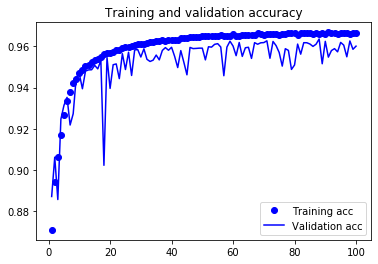

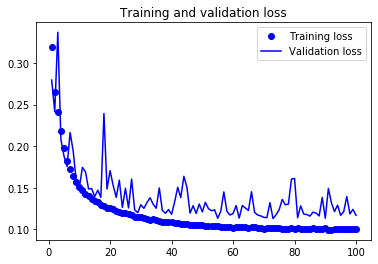

In [27]:
plot_model_training_results(history)

In [28]:
y_predicted = rnn_model.predict_classes(X_test)

# the output is provided as a list of lists (as if the output of the classifier 
# would have been multidimensional (binary classifier as a special case of
# multiclass classifier)) so flatten out this list of list
y_predicted = [item for sublist in y_predicted for item in sublist]

accuracy = np.mean(y_predicted == y_test)
print("Accuracy of the simpleRNN model on the holdout set of size {} is {}".format(len(y_test), accuracy))

Accuracy of the simpleRNN model on the holdout set of size 138754 is 0.9611110310333396


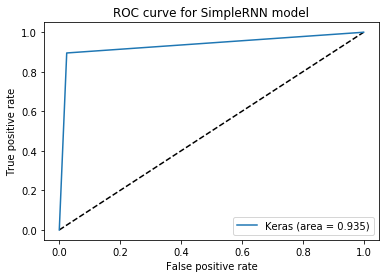

In [29]:

plot_roc_curve(y_test, y_predicted, "SimpleRNN")

Confusion matrix, without normalization
[[110993   2776]
 [  2620  22365]]


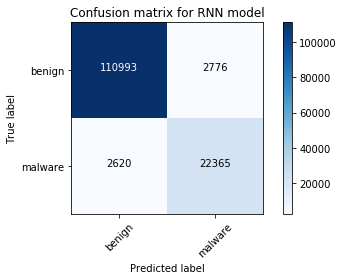

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(list(y_test), y_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'],
                      title='Confusion matrix for RNN model')

In [31]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113769
           1       0.89      0.90      0.89     24985

    accuracy                           0.96    138754
   macro avg       0.93      0.94      0.93    138754
weighted avg       0.96      0.96      0.96    138754



In [0]:
y_predicted_rnn = y_predicted

##1 D CNN
 using a 1D CNN layer with 64 kernels .  achieved the  97% f1 scores accuracy(similar with simple rnn) , also, the results got 98% accuracy on benign URLs and 92% on malicious URLs.

In [33]:

from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalMaxPooling1D
max_features = len(dct)
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, 64, input_length=50))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, 5, activation='relu'))5
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    
print(cnn_model.summary())

history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            11456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


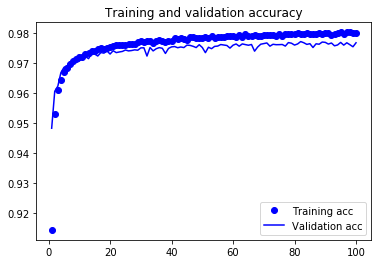

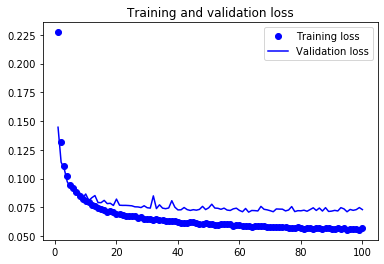

In [39]:
plot_model_training_results(history)

In [34]:
# determine accuracy on holdout set
y_predicted = cnn_model.predict_classes(X_test)

# the output is provided as a list of lists (as if the output of the classifier 
# would have been multidimensional (binary classifier as a special case of
# multiclass classifier)) so flatten out this list of list
y_predicted = [item for sublist in y_predicted for item in sublist]

accuracy = np.mean(y_predicted == y_test)
print("Accuracy of the CNN model on the holdout set of size {} is {}".format(len(y_test), accuracy))

Accuracy of the CNN model on the holdout set of size 138754 is 0.9768727388039263


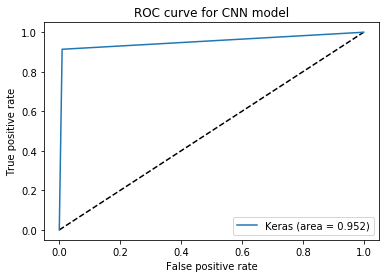

In [35]:
plot_roc_curve(y_test, y_predicted, "CNN")

Confusion matrix, without normalization
[[112712   1057]
 [  2152  22833]]


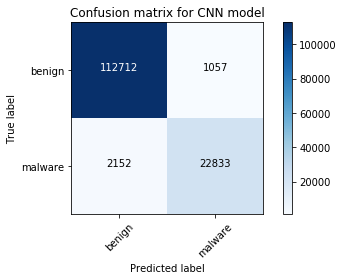

In [36]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(list(y_test), y_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'],
                      title='Confusion matrix for CNN model')

In [37]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113769
           1       0.96      0.91      0.93     24985

    accuracy                           0.98    138754
   macro avg       0.97      0.95      0.96    138754
weighted avg       0.98      0.98      0.98    138754



In [0]:
y_predicted_cnn = y_predicted

###3.3 Comparison betwen SimpleRNN and CNN for text classificiation###

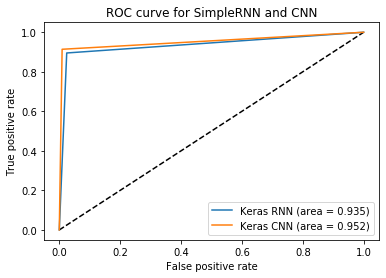

In [40]:
fpr_keras_rnn, tpr_keras_rnn, thresholds_keras_rnn = roc_curve(y_test, y_predicted_rnn)
fpr_keras_cnn, tpr_keras_cnn, thresholds_keras_cnn = roc_curve(y_test, y_predicted_cnn)
  
auc_keras_rnn = auc(fpr_keras_rnn, tpr_keras_rnn)
auc_keras_cnn = auc(fpr_keras_cnn, tpr_keras_cnn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_rnn, tpr_keras_rnn, label='Keras RNN (area = {:.3f})'.format(auc_keras_rnn))
plt.plot(fpr_keras_cnn, tpr_keras_cnn, label='Keras CNN (area = {:.3f})'.format(auc_keras_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for SimpleRNN and CNN')
plt.legend(loc='best')
plt.show()


for rnn and cnn in this case, the overall accuracy from f1 socres of both of them(96% and 98%)  are very similar. However, the CNN obtained better performance for identifying the malicious URLs at 92% ,compared to RNN which got only as compared to 86% for the counterpart.  Also, the plot above showed that Cnn attained  better AUC value  0.952 , when the RNN is with 0.935 auc . Therefore, we should use CNN for identfying true malicious URLS 
.In addition, the training time for CNN is much shorter than Rnn. 